# <center>Metody Numeryczne</center>

# Laboratorium 6: Iteracyjne równania liniowe i macierze rzadkie


**Wykonał:** \<imię i nazwisko\>

<br>

### **Metoda zaliczenia:**

Podczas zajęć należy wykonać poniższe polecenia oraz udzielić odpowiedzi na pytania zamieszczone w treści zadań. 

Wszystkie funkcje wymagane w ramach ćwiczenia należy zaimplementować w pliku `main.py`. Poprawność ich działania należy zweryfikować za pomocą testów jednostkowych dostępnych w pliku `test_main.py`.

### **Cel zajęć:**

Celem zajęć jest zapoznanie się z numerycznymi metodami rozwiązywania układów równań liniowych w postaci macierzowej, w szczególności z wykorzystaniem rzadkich macierzy prostokątnych.


Dana jest prostokątna, [rzadka](https://en.wikipedia.org/wiki/Sparse_matrix) macierz $\mathbf{A}$ o wymiarach $m \times n$ oraz wektor kolumnowy $\mathbf{b}$ o wymiarach $m \times 1$. Należy rozwiązać układ równań postaci:
 
$$
\mathbf{Ax}=\mathbf{b}
$$
  
gdzie:
- $\mathbf{A}$ - macierz współczynników z lewej strony równania, 
- $\mathbf{x}$ - wektor kolumnowy zmiennych,
- $\mathbf{b}$ - wektor kolumnowy wyników prawej strony równania. 

Do oceny jakości rozwiązania wykorzystywać będziemy residuum (ang. *residual*):

$$
\mathbf{r}=\mathbf{b}-\mathbf{Ax}
$$


### **Uwagi wstępne:**
- Funkcje wymagające implementacji (lub zaimplementowane na poprzednich laboratoriach) oznaczone są pochyłą czcionką maszynową (np. *`my_func()`*).

- W skrypcie stosuje się następujące skróty:

    - `np` - `numpy`,
    - `sp` - `scipy`.

---

In [22]:
# !python -m pip install numpy scipy matplotlib

import main

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy as sp
from scipy.sparse.linalg import cg

---

### **Zadanie 1.**

W macierzach rzadkich większość elementów jest zerami, więc przechowywanie całych macierzy w pamięci jest nieefektywne. W celu optymalizacji macierze te zapisuje się w przeznaczonych do tego [formatach przechowywania danych](https://docs.scipy.org/doc/scipy/reference/sparse.html#usage-information), jakie udostępnia m.in. moduł [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html). W ramach laboratorium korzystać będziemy z formatu [Compressed Sparse Column (CSC)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_array.html).

1. Zapoznaj się z różnymi formatami przechowywania macierzy rzadkich w pamięci.

2. Dla $10$ równo rozmieszczonych wartości $m$ z zakresu $[100, 10000]$ wygeneruj macierze rzadkie wymiaru $m \times m$ używając [`sp.sparse.random_array()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.random_array.html) z parametrem `density=0.01` oraz parametrem `format` ustawionym tak, aby wygenerowane macierze zapisane zostały w formacie CSC.

2. Porównaj ile pamięci zajmują te same macierze zapisane w formacie `numpy.ndarray` oraz w formacie `scipy.sparse.csc_array`. W tym celu przekonwertuj kopie macierzy utworzonych w poprzednim punkcie do formatu `numpy.ndarray` używając odpowiedniej metody z modułu `scipy.sparse`. Wynik zaprezentuj na jednym wykresie typu *scatter plot*.

3. Opisz wnioski wynikające z wykresu.

> **Wskazówka:** Do obliczenia rozmiaru zmiennych skorzystaj z fragmentu kodu podanego poniżej.


Rozmiary boczne (s): [  100  1200  2300  3400  4500  5600  6700  7800  8900 10000]
Pamięć CSC [B]: [1604, 177604, 644004, 1400804, 2448004, 3785604, 5413604, 7332004, 9540804, 12040004]
Pamięć Standardowa [B]: [80000, 11520000, 42320000, 92480000, 162000000, 250880000, 359120000, 486720000, 633680000, 800000000]


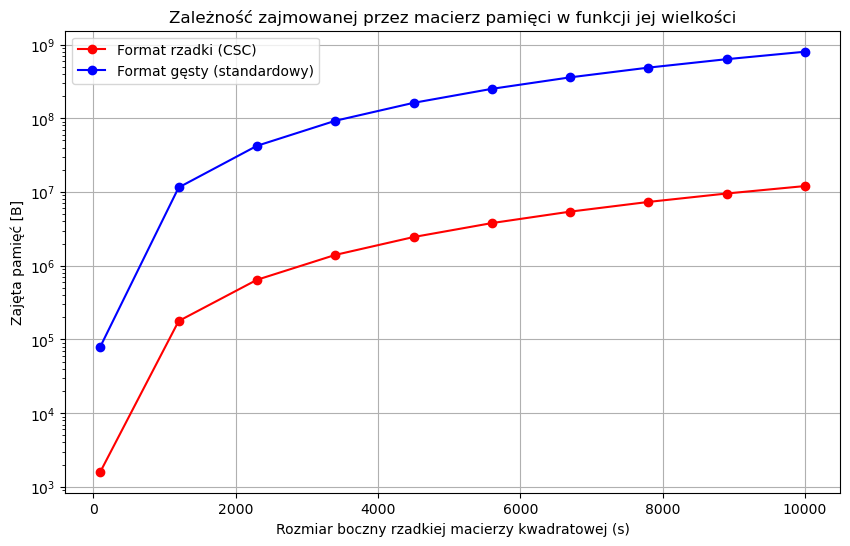

In [3]:
# ===== Twoja implementacja tutaj =====
sizes = np.linspace(100, 10000, 10, dtype=int)
csc_size = []
mtx_size = []

for s in sizes:
    A = sparse.random(s, s, density=0.01, format='csc', dtype=np.float64)
    
    # Obliczenie pamięci w CSC
    csc_mem = A.data.nbytes + A.indices.nbytes + A.indptr.nbytes
    csc_size.append(csc_mem)
    
    # Obliczenie pamięci w formacie gęstym
    mtx_size.append(A.toarray().nbytes)

print("Rozmiary boczne (s):", sizes)
print("Pamięć CSC [B]:", csc_size)
print("Pamięć Standardowa [B]:", mtx_size)

# Wykres
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sizes, csc_size, 'ro-', label='Format rzadki (CSC)')
ax.plot(sizes, mtx_size, 'bo-', label='Format gęsty (standardowy)')

ax.set(title='Zależność zajmowanej przez macierz pamięci w funkcji jej wielkości',
       xlabel='Rozmiar boczny rzadkiej macierzy kwadratowej (s)',
       ylabel='Zajęta pamięć [B]',yscale='log')
ax.grid(True)
ax.legend()

plt.show()

Można zauważyć, że przechowywanie macierzy rzadkiej w formacie csc jest bardziej wydajne niż przechowywanie jej jak zwykłej macierzy 

---

### **Zadanie 2.**

Korzystając z wiedzy zdobytej podczas realizacji **Zadania 1.** wykonaj polecenia.

1. Wygeneruj macierze rzadkie $\mathbf{A}$ i $\mathbf{B}$ o wymiarach $1000 \times 1000$. Zapisz je w formatach `scipy.sparse.csc_array` oraz `numpy.ndarray`.

2. Porównaj czas potrzebny na wykonanie mnożenia macierzowego $\mathbf{AB}$ dla macierzy zapisanych w formacie `numpy.ndarray` oraz `scipy.sparse.csc_array`.

3. Opisz z czego wynika różnica.

In [4]:
# ===== Twoja implementacja tutaj =====
size = 1000
A = sp.sparse.random(size, size, density=0.01, format='csc')
B = sp.sparse.random(size, size, density=0.01, format='csc')
A_toarray = A.toarray()
B_toarray = B.toarray()

print("csc")
%timeit A@B

print("toarray")
%timeit A_toarray@B_toarray


csc
978 μs ± 19.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
toarray
24.5 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


---

Zauważalna różnica w czasie wykonania pomnożenia macierzy 
A i B dla macierzy zapisanych w formacie scipy.sparse.csc_array i numpy.ndarray wynika z różnicy w reprezentacji i przechowywaniu danych.

scipy.sparse.csc_array: Jest to format rzadkiej macierzy, który przechowuje tylko niezerowe elementy, co oznacza, że wymaga mniej pamięci, jeśli macierz jest rzadko wypełniona. Działania na takich macierzach są zazwyczaj szybsze, jeśli chodzi o rozmiar pamięci, ale mogą być wolniejsze przy operacjach wymagających pełnej reprezentacji, takich jak mnożenie macierzy, ponieważ wymaga to konwersji do pełnej macierzy, co może być kosztowne czasowo.

numpy.ndarray: Jest to format pełnej macierzy, który przechowuje wszystkie elementy, niezależnie od tego, czy są one zerowe, czy nie. Mnożenie takich macierzy jest zwykle szybsze, ponieważ operacje na pełnych macierzach są bardziej zoptymalizowane w NumPy.

### **Zadanie 3.**

Aby metody iteracyjne znalazły rozwiązanie układu równań $\mathbf{Ax}=\mathbf{b}$ należy zadbać o to aby macierz $\mathbf{A}$ była [diagonalnie zdominowana](https://en.wikipedia.org/wiki/Diagonally_dominant_matrix). Przekształcenie dowolnej macierzy do tej postaci jest skomplikowanym zagadnieniem, które nie będzie poruszane w ramach tego laboratorium. Na potrzeby zadania należy jedynie sprawdzić czy używana macierz posiada tę własność.

**Punkt 1.**

Zaimplementuj funkcję *`is_diagonally_dominant()`* sprawdzającą czy macierz jest diagonalnie zdominowana.

> **Wskazówka:** W implementacji nie należy używać pętli *for*, ponieważ biblioteka NumPy zawiera funkcje, które znacznie wydajniej iterują po elementach tablic typu `numpy.ndarray`. Lepiej skorzystać z funkcji [`np.sum()`](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) oraz [`np.diagonal()`](https://numpy.org/doc/stable/reference/generated/numpy.diagonal.html).

<br>

**Punkt 2.**

Poniżej znajduje się zaimplementowana funkcja `generate_matrix()`. Przy jej pomocy wygeneruj macierz $\mathbf{A}$ o wymiarach $1000 \times 1000$. Następnie zweryfikuj czy wygenerowana macierz jest diagonalnie zdominowana. Wygeneruj również wektor wartości losowych $\mathbf{b}$ o długości $1000$.

<br>

**Punkt 3.**

Istnieje wiele metod iteracyjnego rozwiązywania równań, natomiast nie różnią się one znacząco od siebie w kwestii wywołania metody, dlatego w dalszej części zadania należy wybrać jedną z metod: [GMRES](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html) lub [Conjugate Gradient](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.cg.html) i dla niej przeprowadzić dalszą analizę. 

1. Korzystając z funkcji *`residual_norm()`*, oraz macierzy zdefiniowanych w **Punkcie 2.**, zbadaj wpływ argumentów `rtol` i `maxiter` na działanie wybranej metody. Sporządź wykresy przedstawiające wartość normy residuum w zależności od zmiany podanych parametrów.

2. Opisz zaobserwowane zależności.

>**Wskazówka:** Metoda *Conjugate Gradient* wymaga aby macierz była dodatnio określona. Można to zapewnić poprzez podanie argumentu `is_symmetric=True` do funkcji `generate_matrix()`.


In [24]:
# Implementacja funkcji generate_matrix().

from scipy.sparse import diags_array, csc_array
from scipy.sparse import issparse

def generate_matrix(m: int = 1000, is_symmetric: bool = False) -> csc_array:
    """Funkcja generująca rzadką, diagonalnie zdominowaną macierz rozmiaru m x m.

    Parameters:
        m (int): Wymiar macierzy.
        is_symmetric (bool): Czy macierz ma być symetryczna.

    Returns:
        (scipy.sparse.csc_array): Macierz rzadka, diagonalnie zdominowana (m,m).

    Raises:
        TypeError: Jeśli 'm' nie jest liczbą całkowitą lub 'is_symmetric' nie 
            jest wartością logiczną.
        ValueError: Jeśli 'm' jest mniejsze niż 5.
    """
    if not isinstance(m, int):
        raise TypeError(
            f"Argument 'm' musi być liczbą całkowitą, otrzymano: {type(m).__name__}."
        )
    if not isinstance(is_symmetric, bool):
        raise TypeError(
            f"Argument 'is_symmetric' musi być wartością logiczną, otrzymano: {type(is_symmetric).__name__}."
        )
    if m < 5:
        raise ValueError("Argument 'm' musi być większy lub równy 5.")

    if is_symmetric:
        num_upper_diags = np.random.randint(2, m // 2)
        diagonal_values = np.random.rand(num_upper_diags)
        matrix = diags_array(
            diagonal_values, offsets=np.arange(1, num_upper_diags + 1), shape=(m, m)
        )
        matrix = matrix + matrix.T
    else:
        num_upper_diags = np.random.randint(2, m // 2)
        num_lower_diags = np.random.randint(2, m // 2)
        diagonal_values = np.random.rand(num_upper_diags + num_lower_diags)
        matrix = diags_array(
            diagonal_values,
            offsets=np.arange(-num_lower_diags, num_upper_diags),
            shape=(m, m),
        )

    row_sums = np.asarray(matrix.sum(axis=1)).flatten()
    diagonal_vals = row_sums - np.abs(matrix.diagonal()) + np.random.rand(m)
    matrix.setdiag(diagonal_vals)

    return matrix.tocsc()

def is_diagonally_dominant(A: np.ndarray | sp.sparse.csc_array) -> bool | None:

    if not isinstance(A, (np.ndarray, sp.sparse.csc_array)):
        return None
    
    if A.ndim !=2:
        return None
    
    if A.shape[0] != A.shape[1]:
        return None

    if issparse(A):
        A = A.toarray()

    diag_elements = np.abs(np.diagonal(A))

    row_sums = np.sum(np.abs(A), axis=1) - diag_elements

    return np.all(diag_elements > row_sums)

def residual_norm(A: np.ndarray, x: np.ndarray, b: np.ndarray):
    if not isinstance(A, np.ndarray) or not isinstance(x, np.ndarray) or not isinstance(b, np.ndarray):
        return None
    
    if A.shape[1] != x.shape[0]:
        return None  
    if A.shape[0] != b.shape[0]:
        return None  

    if x.ndim != 1 or b.ndim != 1:
        return None
    
    residual = b - A.dot(x)
    norm = np.linalg.norm(residual)
    
    return norm


True


c:\Users\IGOR\anaconda3\Lib\site-packages\scipy\sparse\linalg\_isolve\iterative.py:404: RuntimeWarning: invalid value encountered in scalar divide
  beta = rho_cur / rho_prev


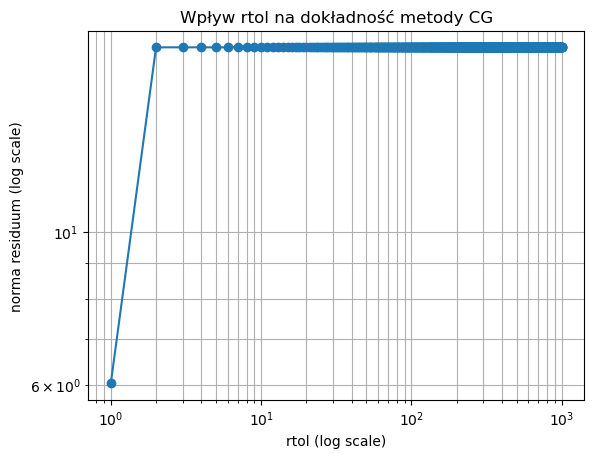

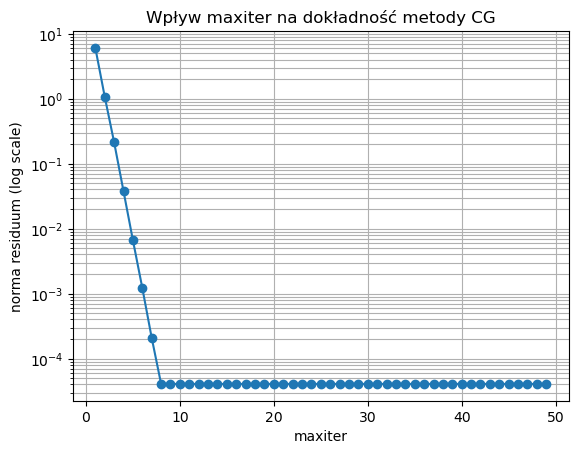

In [ ]:
# ===== Twoja implementacja tutaj =====
A = generate_matrix(1000, is_symmetric=True)
b = np.random.rand(1000,)
print(is_diagonally_dominant(A))


rtox = range(0, 1000)
max_iters = range(1, 50)

results_rtol = []
results_maxiter = []

# --- Wpływ rtol ---
for r in rtox:
    x, info = cg(A, b, rtol=r)
    res = residual_norm(A.toarray(), x, b)
    results_rtol.append(res)

# --- Wpływ maxiter ---
for it in max_iters:
    x, info = cg(A, b, maxiter=it)
    res = residual_norm(A.toarray(), x, b)
    results_maxiter.append(res)

# --- Wykres: wpływ rtol ---
plt.figure()
plt.plot(rtox, results_rtol, marker="o")
plt.xscale("log")           # rtol ma sens w log skali
plt.yscale("log")           # norma residuum w log skali
plt.xlabel("rtol (log scale)")
plt.ylabel("norma residuum (log scale)")
plt.title("Wpływ rtol na dokładność metody CG")
plt.grid(True, which="both")
plt.show()

# --- Wykres: wpływ maxiter ---
plt.figure()
plt.plot(max_iters, results_maxiter, marker="o")
plt.yscale("log")           # większa czytelność
plt.xlabel("maxiter")
plt.ylabel("norma residuum (log scale)")
plt.title("Wpływ maxiter na dokładność metody CG")
plt.grid(True, which="both")
plt.show()


1. Zależność od rtol:
Przy zakresie rtol od 0 do 1000 metoda Conjugate Gradient praktycznie nie zmienia dokładności rozwiązania — residuum pozostaje stałe, ponieważ algorytm osiąga swoją maksymalną możliwą precyzję niezależnie od wartości tolerancji. Zwiększanie rtol nie pogarsza wyniku, a zmniejszanie go poniżej pewnego progu też nic nie poprawia. Oznacza to, że dokładność ograniczana jest właściwościami macierzy, a nie ustawieniami tolerancji.

2. Zależność od maxiter:
Dla zakresu maxiter od 1 do 50 norma residuum zmniejsza się wyraźnie przy zwiększaniu liczby iteracji — metoda stopniowo dochodzi do zbieżności. Jednak po przekroczeniu pewnej liczby iteracji (około 30–40) dalsze zwiększanie maxiter nie poprawia już rozwiązania, bo algorytm osiąga pełną dokładność. Pokazuje to, że maxiter ma realny wpływ tylko wtedy, gdy iteracji jest zbyt mało.

---

**Materiały uzupełniające:**
- [Scipy Lecture Notes](http://www.scipy-lectures.org/index.html)
- [NumPy for Matlab users](https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html#numpy-for-matlab-users)
- [Python Tutorial - W3Schools](https://www.w3schools.com/python/default.asp)
- [NumPy](https://www.numpy.org)
- [Matplotlib](https://matplotlib.org/)
- [Anaconda](https://www.anaconda.com/)
- [Learn Python for Data Science](https://www.datacamp.com/learn-python-with-anaconda?utm_source=Anaconda_download&utm_campaign=datacamp_training&utm_medium=banner)
- [Learn Python](https://www.learnpython.org/)
- [Wujek Google](https://google.pl) i [Ciocia Wikipedia](https://pl.wikipedia.org/wiki/Wikipedia:Strona_g%C5%82%C3%B3wna)